Let's import what's needed:

In [1]:
%matplotlib inline
!pip3 install torch torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If you do not have e.g. PyTorch installed in a Colab environment, you can do
`!pip install torch torchvision`.

# Task 1

Let's create a tensor:

In [2]:
xx = torch.linspace(-3, 3, 50)
xx

tensor([-3.0000, -2.8776, -2.7551, -2.6327, -2.5102, -2.3878, -2.2653, -2.1429,
        -2.0204, -1.8980, -1.7755, -1.6531, -1.5306, -1.4082, -1.2857, -1.1633,
        -1.0408, -0.9184, -0.7959, -0.6735, -0.5510, -0.4286, -0.3061, -0.1837,
        -0.0612,  0.0612,  0.1837,  0.3061,  0.4286,  0.5510,  0.6735,  0.7959,
         0.9184,  1.0408,  1.1633,  1.2857,  1.4082,  1.5306,  1.6531,  1.7755,
         1.8980,  2.0204,  2.1429,  2.2653,  2.3878,  2.5102,  2.6327,  2.7551,
         2.8776,  3.0000])

The API is very similar to Numpy, but there are a couple of differences.

Let's plot our function $f(x) = \sigma^2(x)$:

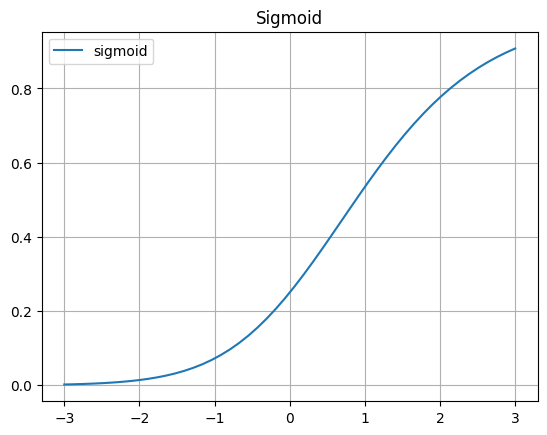

In [3]:
yy = torch.sigmoid(xx)**2  # yes, sigmoid is built in!
plt.plot(xx, yy, label='sigmoid')
plt.title("Sigmoid")
plt.legend()
plt.grid(True)
plt.show()

For a bit more complicated function, calculate its derivative

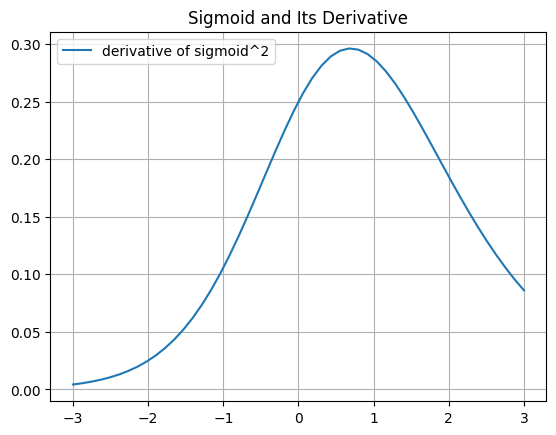

In [4]:
derivative_analytic = (2*np.exp(-xx))/((np.exp(-xx)+1)**3)

plt.plot(xx, derivative_analytic, label="derivative of sigmoid^2")
plt.title("Sigmoid and Its Derivative")
plt.legend()
plt.grid(True)
plt.show()

And now calculate the same using automatic differentiation (AD), that is, using
PyTorch's builtin mechanisms:

In [5]:
N = 50
gradient = torch.zeros(N)
# Unfortunately, PyTorch can only take the gradient at a single point at a
# time, so we need a for loop:
for i, x_value in enumerate(np.linspace(-3, 3, N)):
    # we will mark the variables we need the gradient _with respect to_
    # xx = torch.linspace(-3, 3, 500, requires_grad=True)
    x = torch.tensor(x_value, requires_grad=True)
    if i == 0:
        print('`x` requires grad:', x.requires_grad)
    # we need to complete the calculations as before (this is sometimes called
    # the forward pass)
    y = torch.sigmoid(x)**2
    # this line calculates the gradients for all variables that "need grad"
    # (sometimes called the backward pass)
    y.backward()
    # and now, what we have been waiting for:
    gradient[i] = x.grad
# Always check with `allclose` and not `==` if they are floating point tensors
print('AD and analytic gradients equal:',
      torch.allclose(derivative_analytic, gradient))

`x` requires grad: True
AD and analytic gradients equal: True


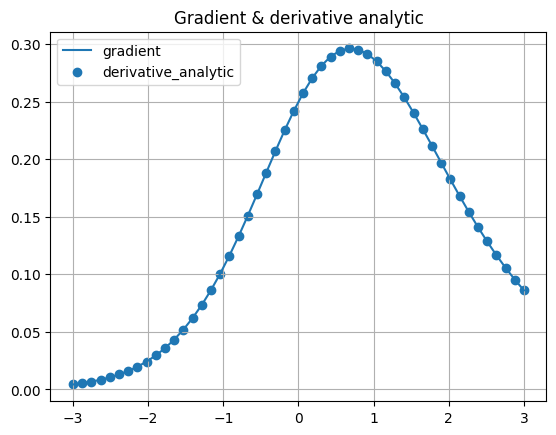

In [6]:
plt.plot(xx, gradient, label="gradient")
plt.scatter(xx, derivative_analytic, label="derivative_analytic")
plt.title("Gradient & derivative analytic")
plt.legend()
plt.grid(True)
plt.show()

# Task 2

This is going to be our objective function to optimise (minimise):

In [7]:
def f(x):
    x = torch.atleast_2d(x)
    assert x.shape[1] == 2, 'Second dimension should contain the input features'
    # Himmelblau
    x1 = x[:, 0]
    x2 = x[:, 1]
    return ((x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2)

In [8]:
def plot_contour():
    N = 500
    xx = torch.linspace(-6, 6, N)
    x1, x2 = torch.meshgrid(xx, xx, indexing='ij')
    x = torch.stack((x1.ravel(), x2.ravel()), axis=1)
    y = f(x).reshape(N, N)
    fig, (ax, ax_log) = plt.subplots(
        1, 2, figsize=(10, 5), layout='constrained')
    ax.contourf(x1, x2, y, levels=20)
    ax.grid()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Linear scale')
    ax_log.contourf(x1, x2, torch.log(y), levels=20)
    ax_log.grid()
    ax_log.set_xlabel('$x_1$')
    ax_log.set_ylabel('$x_2$')
    ax_log.set_title('Log scale')
    return fig, (ax, ax_log)

Let's start by optimising by hand:

In [9]:
# initial guess
x = torch.tensor([0., 0.], requires_grad=True)
# we need to clone and detach so as not to copy the meta information, only the
# values
trajectory = [x.clone().detach()]
step_size = 0.1
for i in range(10):
    # zero out the gradients (because we reuse the tensor)
    x.grad = None
    # forward pass
    y = f(x)
    # calculate the gradient
    y.backward()
    # step in the direction of the negative gradient
    # we need to temporarily disable autograd for this:
    with torch.no_grad():
        x.add_(x.grad * step_size)
    # save trajectory
    trajectory.append(x.clone().detach())
trajectory_manual = torch.stack(trajectory)
trajectory_manual

tensor([[ 0.0000e+00,  0.0000e+00],
        [-1.4000e+00, -2.2000e+00],
        [ 4.1824e+00, -1.3152e+00],
        [ 1.2626e+01,  2.9255e-01],
        [ 7.6484e+02,  3.0704e+01],
        [ 1.7897e+08,  1.3792e+05],
        [ 2.2932e+24,  7.4656e+15],
        [        inf,         inf],
        [        inf,         inf],
        [        inf,         inf],
        [        inf,         inf]])

And by using the built in optimisers:

In [10]:
# initial guess
x = torch.tensor([0., 0.], requires_grad=True)
# we need to clone and detach so as not to copy the meta information, only the
# values
trajectory = [x.clone().detach()]
# we need to tell the optimiser which parameters to optimise
optimiser = optim.SGD(params=[x], lr=step_size)
# TODO other optimisers
for i in range(10):
    # zero out the gradients
    optimiser.zero_grad()
    # forward pass
    y = f(x)
    # calculate the gradient
    y.backward()
    # step in the direction of the negative gradient
    optimiser.step()
    # save trajectory
    trajectory.append(x.clone().detach())
trajectory_sgd = torch.stack(trajectory)
trajectory_sgd

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 1.4000e+00,  2.2000e+00],
        [ 5.3824e+00,  4.2368e+00],
        [-4.5695e+01, -2.7884e+01],
        [ 3.7264e+04,  7.6469e+03],
        [-2.0698e+13, -1.7925e+11],
        [        inf,  2.3039e+33],
        [        nan,        -inf],
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]])

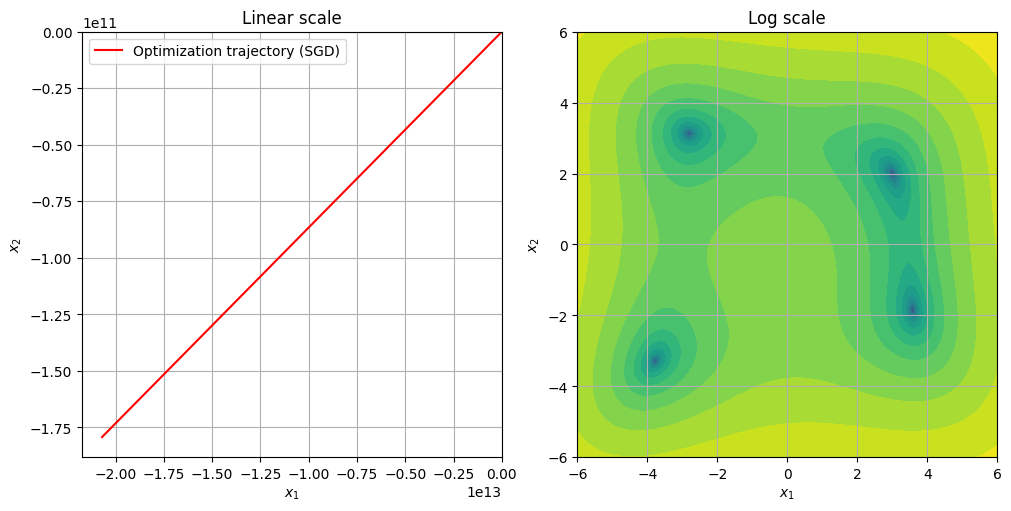

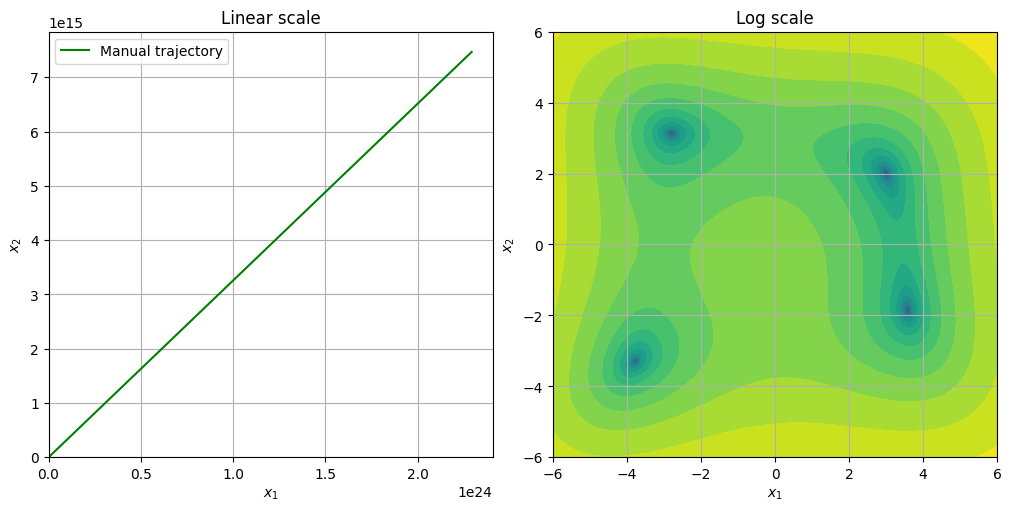

In [11]:
fig1, (ax1, ax_log1) = plot_contour()
ax1.plot(trajectory_sgd[:, 0], trajectory_sgd[:, 1], color='red', label='Optimization trajectory (SGD)')
ax1.legend()
plt.show()

fig2, (ax2, ax_log2) = plot_contour()
ax2.plot(trajectory_manual[:, 0], trajectory_manual[:, 1], color='green', label='Manual trajectory')
ax2.legend()
plt.show()

# Task 3

Let's start by loading the dataset:

In [12]:
batch_size = 32
num_epochs = 10

In [13]:
train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True)
# PyTorch has these DataLoaders which make batching and iterating really
# convenient
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False)

Let's define our model, which is going to be a neural network:

And then do the training loop:

Epoch [1/10], Train Loss: 0.8660, Test Loss: 0.8736
Epoch [2/10], Train Loss: 0.8771, Test Loss: 0.8834
Epoch [3/10], Train Loss: 0.8871, Test Loss: 0.8929
Epoch [4/10], Train Loss: 0.8918, Test Loss: 0.8975
Epoch [5/10], Train Loss: 0.8958, Test Loss: 0.8997
Epoch [6/10], Train Loss: 0.8929, Test Loss: 0.9011
Epoch [7/10], Train Loss: 0.8992, Test Loss: 0.9048
Epoch [8/10], Train Loss: 0.9023, Test Loss: 0.9073
Epoch [9/10], Train Loss: 0.8993, Test Loss: 0.9061
Epoch [10/10], Train Loss: 0.8987, Test Loss: 0.9038


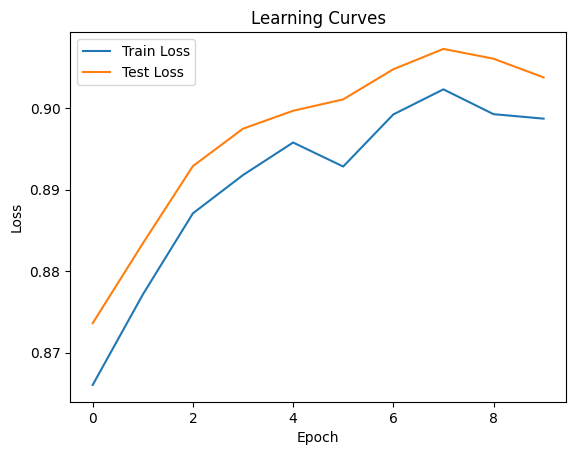

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

batch_size = 32
num_epochs = 10

# convert PIL images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# define the neural network model
class MnistClassifier(nn.Module):

    NUM_CLASSES = 10
    NUM_INPUT_CHANNELS = 1

    def __init__(self):
        # always call super with PyTorch models
        super().__init__()
        # the parameters within these will automatically get registered, and
        # will be tracked by the optimiser
        self.conv1 = nn.Conv2d(
            in_channels=self.NUM_INPUT_CHANNELS, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(
            in_channels=10, out_channels=5, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(
            in_channels=5, out_channels=1, kernel_size=3, stride=2)
        self.fc = nn.Linear(1 * 5 * 5, self.NUM_CLASSES)

    def forward(self, x):
        # Here is the actual forward pass. Simply call each layer with the
        # input data:
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        # flatten every dimension except the batch dimension
        B = x.shape[0]
        x = x.view(B, -1)
        x = self.fc(x)
        # note that we don't have a finaly nonlinearity, in this case, it is
        # going to be in the loss
        return x

# model, loss function, and optimizer
model = MnistClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Training loop
# def train_epoch(train_loader, test_loader, model, optimiser):
#     # TODO use your optimiser to optimise the model parameters
#     for x, y in train_loader:
#         # `x` is your input, `y` is your ground truth output
#         y_estimated = model(x)
#         # calculate the loss
#         # TODO use cross entropy loss
def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_epoch(train_loader, model, criterion, optimizer)
    train_loss = evaluate(train_loader, model)
    test_loss = evaluate(test_loader, model)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

Hidden Size: 3, Test Accuracy: 0.1573
Hidden Size: 4, Test Accuracy: 0.1111
Hidden Size: 5, Test Accuracy: 0.1103
Hidden Size: 6, Test Accuracy: 0.0994
Hidden Size: 7, Test Accuracy: 0.0860
Hidden Size: 8, Test Accuracy: 0.1717
Hidden Size: 9, Test Accuracy: 0.0933


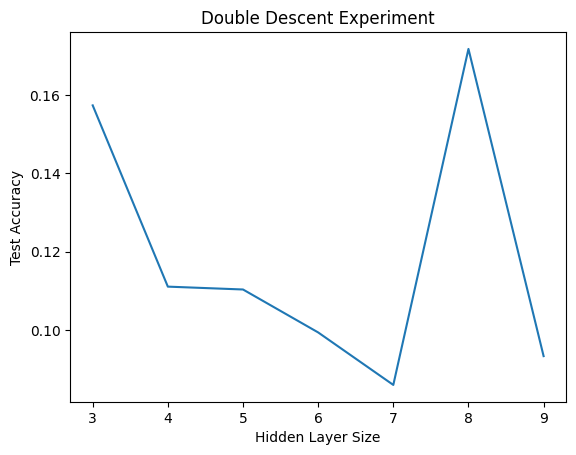

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

num_samples = 4000
num_epochs = 10

# convert PIL images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset with transformations applied !
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Randomly select a subset of training samples
train_subset = torch.utils.data.Subset(train, np.random.choice(len(train), num_samples, replace=False))

# create data loaders for training subset and test set
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=num_samples, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=len(test), shuffle=False)

# define the fully connected neural network with one hidden layer
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input !!!
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# train and evaluate the model
def train_and_evaluate(hidden_size):
    model = FCNN(28*28, hidden_size, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                accuracy = (predicted == labels).float().mean().item()
                test_accuracies.append(accuracy)

    return np.mean(test_accuracies)

hidden_sizes = range(3, 10) # Just 3 to 10 because it was toooo long for 3 to 800
accuracies = []

for hidden_size in hidden_sizes:
    accuracy = train_and_evaluate(hidden_size)
    accuracies.append(accuracy)
    print(f"Hidden Size: {hidden_size}, Test Accuracy: {accuracy:.4f}")

plt.plot(hidden_sizes, accuracies)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Accuracy')
plt.title('Double Descent Experiment')
plt.show()
